## Exploring Strategies with Distributed Data

1. Work with **all** of the data with **spark**

    \+ most accurate reports    
    \- limited by the operations that spark provides, e.g. visualization. 


2. Work with a **sample** of the data with **pandas**

    \+ This lets us use the tools we are already familiar with to explore the data  
    \+ More visualization options  
    \+ Faster iteration   
    \- We are working with a sample, and not the entire data, so we could be missing information.  


3. **Aggregate** the data with **spark**, and then work with the aggregated data locally with **Pandas**

    \+ We won't "miss out" on anything like we have the potential to do when working with sampled data  
    \+ Benefits of working locally in the pandas ecosystem   
    \- However, we are limited by the fact that we have to do aggregation, which usually results in a different shape of data, and information is lost when aggregating.  

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                


## Strategy 1: Work with all the data using Spark

#### How many open and closed cases are there?

In [2]:
#rename df to distinguish as spark df
sdf = df

#groupby case status and get counts for each
sdf.groupBy('case_status').count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



#### What is the average amount of time a case is open?

In [3]:
sdf.groupBy('case_status').agg(mean('case_lifetime')).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108263294778737|
+-----------+------------------+



## Strategy 2: Work with a sample of the data with Pandas

In [4]:
#rename to distinguish pandas df
pdf = sdf.sample(fraction=0.20, seed=123).toPandas()
pdf.head()

,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127332,2018-01-01 00:42:00,2018-01-01 12:29:00,2020-09-26 00:42:00,False,-998.508762,True,Stray Animal,999.000000,Closed,svcCRMLS,"2315 EL PASO ST, San Antonio, 78207",005,-142.644109,78207,219,0.0,0,Animal Care Services,True
1,1014127336,2018-01-01 01:34:00,2018-01-01 13:29:00,2018-01-01 04:34:00,True,0.372164,True,Animal Cruelty(Critical),0.125000,Closed,svcCRMSS,"734 CLEARVIEW DR, San Antonio, 78228",007,0.053166,78228,219,0.0,0,Animal Care Services,True
2,1014127351,2018-01-01 07:07:00,2018-01-02 15:33:00,2018-01-17 08:30:00,False,-14.705648,True,Front Or Side Yard Parking,16.057338,Closed,svcCRMSS,"834 BARREL POINT, San Antonio, 78251",004,-2.100807,78251,219,1.0,1,DSD/Code Enforcement,True
3,1014127358,2018-01-01 07:12:00,2018-01-02 15:35:00,2018-01-17 08:30:00,False,-14.704699,True,Right Of Way/Sidewalk Obstruction,16.054063,Closed,svcCRMSS,"837 BARREL POINT, San Antonio, 78251",004,-2.100671,78251,219,1.0,1,DSD/Code Enforcement,True
4,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True


In [5]:
print(pdf.shape)

(168273, 20)


#### With pandas, we can use visualizations like pairplot

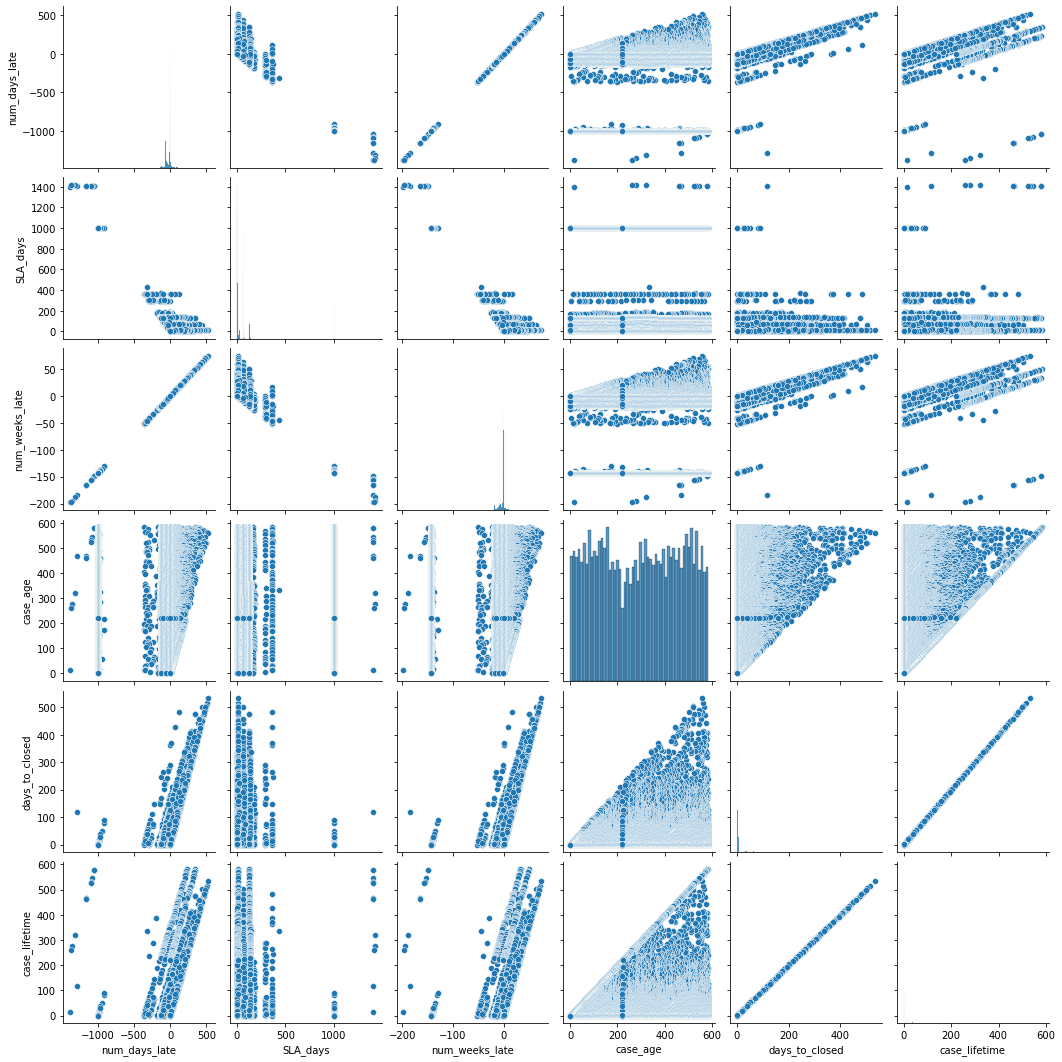

In [6]:
#identify numeric cols that will be useful in a pairplot
numeric_cols = ['num_days_late', 'SLA_days', 'num_weeks_late', 'case_age', 'days_to_closed', 'case_lifetime']

#pairplot selecting only those cols from sample pandas df
sns.pairplot(pdf[numeric_cols])

#### Let's explore one of the variables

<AxesSubplot:ylabel='Frequency'>

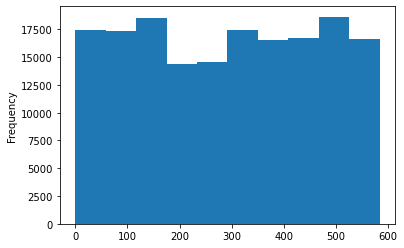

In [7]:
pdf.case_age.plot.hist()

#### Are there departments that are more likely to have late cases than other departments?

<AxesSubplot:xlabel='department', ylabel='case_late'>

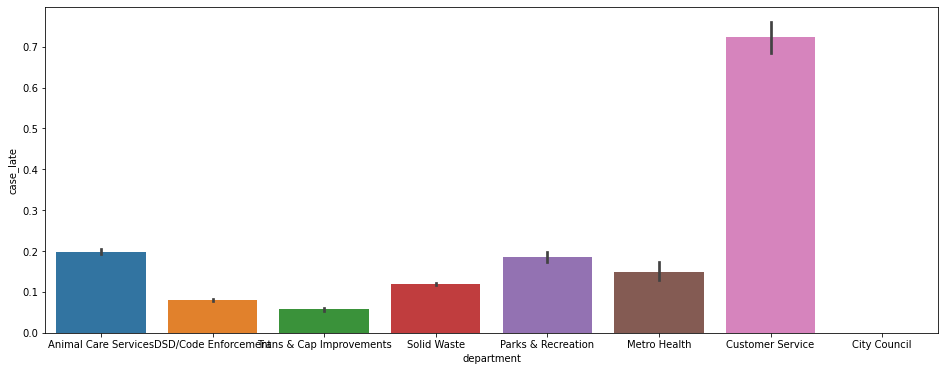

In [8]:
#look at case_late by department
#case late is bool so bar plot converts to 0's and 1's
plt.figure(figsize = (16, 6))
sns.barplot(pdf.department, pdf.case_late)

#### Re-sample w/ a different seed to see if we get similar results

<AxesSubplot:xlabel='department', ylabel='case_late'>

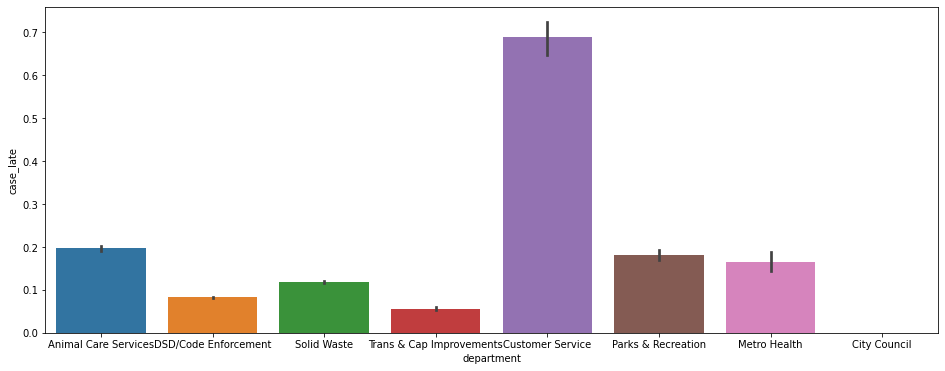

In [9]:
pdf_sample2 = sdf.sample(fraction=0.20, seed=447).toPandas()

#re-plot to see if anything changes
plt.figure(figsize = (16, 6))
sns.barplot(pdf_sample2.department, pdf_sample2.case_late)

#shows similar results, just order of bars have changed

## Strategy 3: Aggregate with spark, and then work with the aggregated data using Pandas

#### Which departments have the most cases?

In [10]:
#group by dpt counts
sdf.groupBy('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [11]:
#convert to pandas
sdf.groupBy('department').count().toPandas()

,department,count
0,Solid Waste,279270
1,Animal Care Services,116915
2,Trans & Cap Improvements,96193
3,Parks & Recreation,19907
4,Customer Service,2849
5,Metro Health,5163
6,City Council,33
7,DSD/Code Enforcement,321374


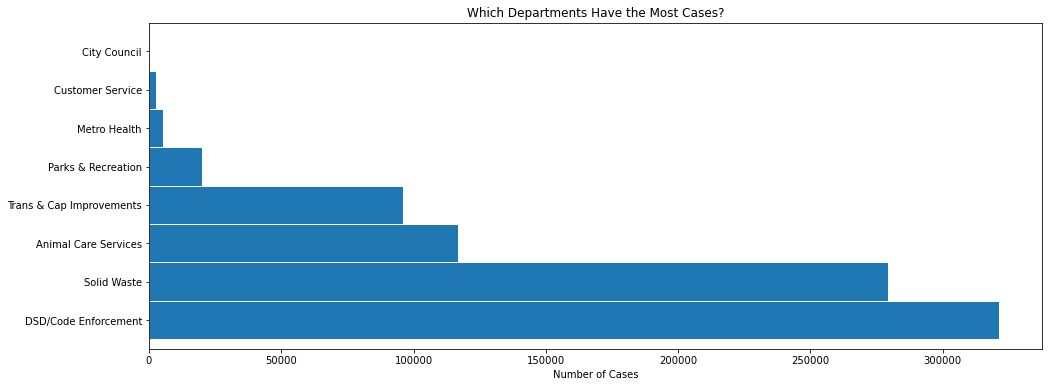

In [12]:
#aggregate in spark
(sdf.groupBy('department')
 .count()
 .toPandas()
 .set_index('department')['count']
 .sort_values(ascending=False)
 .plot.barh(width=1, edgecolor='white', figsize=(16,6))
)

#can edit visual since we are in pandas
plt.title('Which Departments Have the Most Cases?')
plt.ylabel("")
plt.xlabel("Number of Cases")
plt.show()

#### What does the case lifetime look like for each department? 

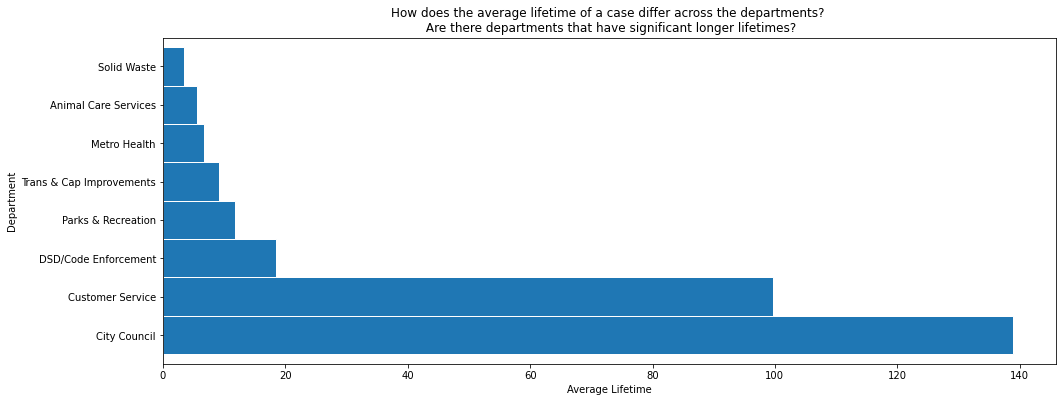

In [17]:
(
    sdf.groupBy('department')
    .agg(mean('case_lifetime').alias('avg_lifetime'))
    #convert to pandas
    .toPandas()
    .set_index('department')
    .avg_lifetime.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor='white', figsize=(16,6))
)

plt.xlabel("Average Lifetime")
plt.ylabel("Department")
plt.title("How does the average lifetime of a case differ across the departments? \n Are there departments that have significant longer lifetimes?")
plt.show()

#### Let's control for case status, and then look at average lifetime by department. That way we can see, of the closed cases, which ones had the longest/shortest lives.

In [20]:
(
    sdf.groupBy('department')
    .pivot('case_status')
    .agg(round(mean('case_lifetime'), 2))
    .orderBy('closed')
    .show(truncate=False)

)

+------------------------+------+------+
|department              |Closed|Open  |
+------------------------+------+------+
|Solid Waste             |3.4   |16.45 |
|Animal Care Services    |5.51  |21.36 |
|Metro Health            |6.82  |4.64  |
|Trans & Cap Improvements|8.0   |54.39 |
|Parks & Recreation      |10.66 |64.72 |
|DSD/Code Enforcement    |15.64 |91.56 |
|City Council            |29.25 |154.07|
|Customer Service        |48.94 |172.94|
+------------------------+------+------+



In [21]:
#convert to pandas
(
    sdf.groupBy('department')
    .pivot('case_status')
    .agg(round(mean('case_lifetime'), 2))
    .orderBy('closed')
    .toPandas()

)

,department,Closed,Open
0,Solid Waste,3.40,16.45
1,Animal Care Services,5.51,21.36
2,Metro Health,6.82,4.64
3,Trans & Cap Improvements,8.00,54.39
4,Parks & Recreation,10.66,64.72
5,DSD/Code Enforcement,15.64,91.56
6,City Council,29.25,154.07
7,Customer Service,48.94,172.94


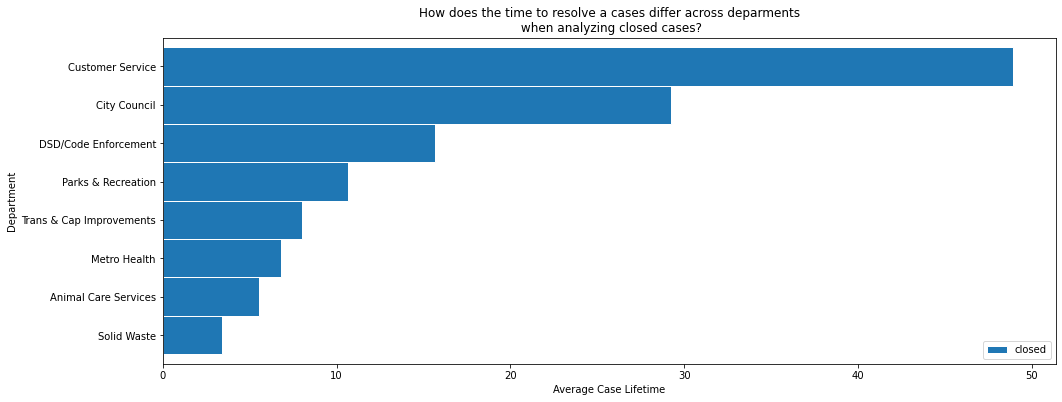

In [14]:
#plot
(
    sdf.groupBy('department')
    .pivot('case_status')
    .agg(round(mean('case_lifetime'), 2))
    .orderBy('closed')
    .select('department', 'closed')
    .toPandas()
    .set_index('department')
    .plot.barh(width=1, edgecolor='white', figsize=(16, 6))
)

plt.xlabel("Average Case Lifetime")
plt.ylabel("Department")
plt.title("How does the time to resolve a cases differ across deparments\n when analyzing closed cases?")
plt.show()

#### Here we will count the number of cases closed and opened on each date, and then explore the resulting time series dataset.

In [15]:
cases_by_day = sdf.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [16]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [17]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [18]:
pdf = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
pdf.head(5)

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173


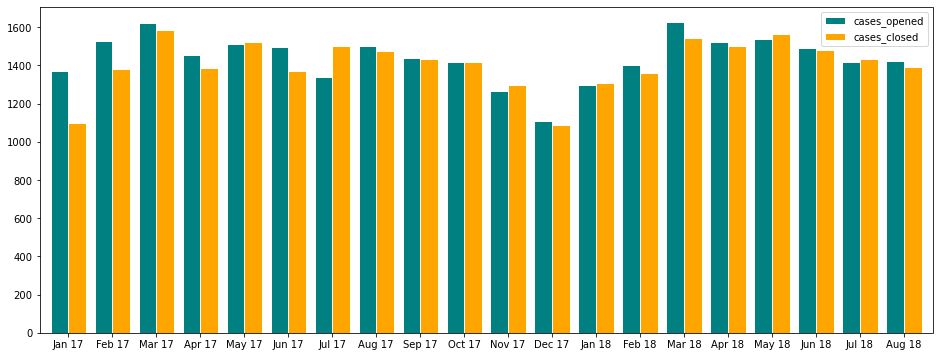

In [19]:
pdf.resample("M").mean().plot.bar(
    figsize=(16, 6), width=0.8, ec="white", color=["teal", "orange"]
)

# pretty x-axis labels
ticks, labels = plt.xticks()
labels = pd.to_datetime([l.get_text() for l in labels]).strftime("%b %y")
plt.xticks(ticks, labels, rotation=0)
None